In [1]:
import pandas as pd
import os
import librosa
import numpy as np
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import pandas as pd
import numpy as np


import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from tqdm.notebook import tqdm

from sklearn.preprocessing import OneHotEncoder

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
X = np.load('mfcc_X_data.npy')
Y = np.load('mfcc_Y_data.npy', allow_pickle='True')

In [3]:
Y_df = pd.DataFrame(Y)
Y_df.head()

,0
0,An-Nas
1,An-Nas
2,An-Nas
3,An-Nas
4,An-Nas


In [4]:
X_df = pd.DataFrame(X)
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-221.180679,126.025711,-50.995396,47.782433,-17.575918,28.504759,-16.543465,4.723109,-16.000511,-13.612542,...,-6.393832,-3.856801,1.254481,6.601337,8.466876,15.015834,4.340286,12.090161,12.014910,26.821383
1,-211.255005,119.753944,-52.348122,63.510727,-21.535557,29.757116,-18.222822,7.571888,-12.699204,-14.380175,...,-6.207137,-4.994766,-0.988067,6.583804,10.860059,22.726280,10.932115,10.071551,1.016532,5.640285
2,-212.992538,111.009041,-51.069992,55.615635,-29.020407,37.870895,-22.575338,4.039803,-10.614483,-17.730742,...,3.250622,3.888988,8.326393,7.663583,4.940736,5.889103,-3.204108,9.284558,7.726558,22.162859
3,-252.801468,135.314240,-43.591640,50.476078,-1.697368,27.965115,-11.784382,10.756843,-10.194268,-16.072851,...,-10.171225,-7.709264,-2.342036,8.532597,15.277192,21.758413,5.262423,8.937285,7.269296,15.028630
4,-155.234695,131.976410,-41.808273,38.996029,-39.036037,46.623611,-22.237730,-8.598266,-6.576684,-20.480564,...,0.876611,-1.357790,-15.314865,3.491620,-9.598725,-5.994679,0.465712,-9.627331,-9.393802,-8.305319


Unison Shuffling

In [5]:
import numpy 


def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = numpy.empty(a.shape, dtype=a.dtype)
    shuffled_b = numpy.empty(b.shape, dtype=b.dtype)
    permutation = numpy.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [6]:
X_pre, y_pre = shuffle_in_unison(X, Y)

In [7]:
print(X_pre.shape)
print(y_pre.shape)

(1210, 40)
(1210,)


One Hot Encoding for 10 Classes

In [8]:
labels = ['An-Nas', 'Al-Falaq','Al-Fil','Quraish','Al-Maun','Al-Kauthar','Al-Kafirun','An-Nasr','Al-Masad','Al-Ikhlas']

In [9]:
y_enc = np.array([labels.index(l) for l in y_pre])
y_enc = tf.one_hot(y_enc, len(labels))

In [10]:
print(y_enc.shape)

(1210, 10)


Train-Test Split

In [11]:
def train_test_split(X, y, test_size):
    n_test = int(X.shape[0] * test_size)
    X_test = X[:n_test]
    y_test = y[:n_test]
    X_train = X[n_test:]
    y_train = y[n_test:]
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_enc, 0.15)

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1029, 40) (1029, 10)
(181, 40) (181, 10)


In [14]:
# X_train, y_train = shuffle_in_unison (X_train, y_train)
# X_test, y_test = shuffle_in_unison (X_test, y_test)

Expand Dimension for CNN-1D, CNN-2D and Transformers

In [15]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis = 2)

print("Shape of X Train", X_train.shape)
print("Shape of X Test", X_test.shape)

Shape of X Train (1029, 40, 1)
Shape of X Test (181, 40, 1)


Reshape for Only Transformer Models and CNN-2D Models

In [16]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 10, 4, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 10, 4, 1)

print(X_train_reshaped.shape, y_train.shape)
print(X_test_reshaped.shape, y_test.shape)

(1029, 10, 4, 1) (1029, 10)
(181, 10, 4, 1) (181, 10)


-  CNN 1D Model For 10 Classes

In [17]:
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import os, time, warnings
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
)

from keras import regularizers
warnings.filterwarnings("ignore")

In [18]:
CNN1D_Model = Sequential()
CNN1D_Model.add(
    Conv1D(
        256,
        5,
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(X_train.shape[1], 1),
    )
)
CNN1D_Model.add(BatchNormalization())
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Flatten())
CNN1D_Model.add(Dense(units=1024, activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(Dense(units=10, activation="softmax"))
CNN1D_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 256)           1536      
                                                                 
 batch_normalization (BatchN  (None, 40, 256)          1024      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 256)           327936    
                                                                 
 dropout (Dropout)           (None, 20, 256)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 256)          0

In [19]:
CNN1D_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [20]:
t0 = time.time()

CNN1D_Results = CNN1D_Model.fit(
    X_train, y_train, batch_size=32, epochs=150, validation_data=(X_test, y_test)
)

CNN1D_Model.save("Model_CNN1D_TrainTestSplit.h5")
print("CNN1D Model Saved")
train_hist_m2 = pd.DataFrame(CNN1D_Results.history)
train_m2 = round(time.time() - t0, 3)

Epoch 1/150
33/33 [==============================] - 3s 42ms/step - loss: 2.4818 - accuracy: 0.1341 - val_loss: 2.2590 - val_accuracy: 0.1823
Epoch 2/150
33/33 [==============================] - 1s 33ms/step - loss: 2.2803 - accuracy: 0.1467 - val_loss: 2.3020 - val_accuracy: 0.1105
Epoch 3/150
33/33 [==============================] - 1s 44ms/step - loss: 2.2485 - accuracy: 0.1710 - val_loss: 2.2106 - val_accuracy: 0.1823
Epoch 4/150
33/33 [==============================] - 1s 43ms/step - loss: 2.1708 - accuracy: 0.1963 - val_loss: 2.0824 - val_accuracy: 0.2320
Epoch 5/150
33/33 [==============================] - 1s 43ms/step - loss: 2.0517 - accuracy: 0.2614 - val_loss: 1.9758 - val_accuracy: 0.2541
Epoch 6/150
33/33 [==============================] - 1s 41ms/step - loss: 1.9975 - accuracy: 0.2760 - val_loss: 1.9691 - val_accuracy: 0.2597
Epoch 7/150
33/33 [==============================] - 2s 51ms/step - loss: 1.9537 - accuracy: 0.2828 - val_loss: 1.8221 - val_accuracy: 0.3370
Epoch 

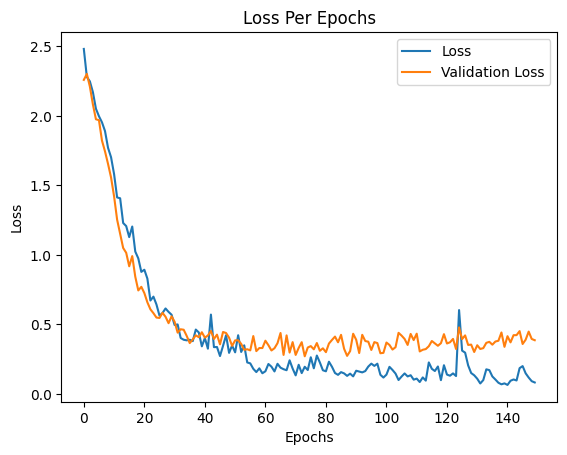

In [21]:
plt.plot(train_hist_m2[["loss", "val_loss"]])
plt.legend(["Loss", "Validation Loss"])
plt.title("Loss Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

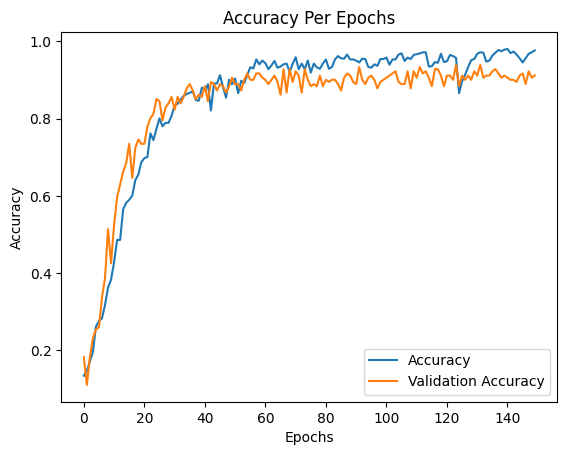

In [22]:
plt.plot(train_hist_m2[["accuracy", "val_accuracy"]])
plt.legend(["Accuracy", "Validation Accuracy"])
plt.title("Accuracy Per Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [23]:
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# import librosa

# # Define the LSTM model architecture
# model = keras.Sequential()
# model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.LSTM(128, return_sequences=True))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.LSTM(128, return_sequences=True))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.LSTM(128))

# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.Dense(10, activation='sigmoid'))


# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# t0 = time.time()

# # CNN1D_Results = CNN1D_Model.fit(
# #     X_train, y_train, batch_size=32, epochs=120, validation_data=(X_test, y_test)
# # )

# # Train the model on the spectrogram data
# # history = model.fit(X_train, y_train, batch_size=32, epochs=120, validation_data=(X_test, y_test))

# history = model.fit(X_pre, y_enc, batch_size=64, epochs=150)

# # model.save("Model2.h5")

# train_hist_m2 = pd.DataFrame(history.history)
# train_m2 = round(time.time() - t0, 3)

# # Save the model
# model.save('lstm_model.h5')
# print("LSTM Model Saved")

In [24]:
# CNN1D_Model = Sequential()
# CNN1D_Model.add(
#     Conv1D(
#         256,
#         5,
#         strides=1,
#         padding="same",
#         activation="relu",
#         input_shape=(X_train.shape[1], 1),
#     )
# )
# CNN1D_Model.add(BatchNormalization())
# CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
# CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
# CNN1D_Model.add(Dropout(0.3))
# CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
# CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
# CNN1D_Model.add(Dropout(0.3))
# CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
# CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
# CNN1D_Model.add(Dropout(0.3))
# CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
# CNN1D_Model.add(Flatten())
# CNN1D_Model.add(Dense(units=1024, activation="relu"))
# CNN1D_Model.add(Dropout(0.3))
# CNN1D_Model.add(Dense(units=10, activation="softmax"))
# CNN1D_Model.summary()


In [25]:
# CNN1D_Model.compile(
#     optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
# )

In [26]:
# t0 = time.time()

# CNN1D_Results = CNN1D_Model.fit(
#     X_train, y_train, batch_size=32, epochs=120, validation_data=(X_test, y_test)
# )

# CNN1D_Model.save("Model2.h5")
# print("CNN1D Model Saved")
# train_hist_m2 = pd.DataFrame(CNN1D_Results.history)
# train_m2 = round(time.time() - t0, 3)

In [27]:
# plt.plot(train_hist_m2[["loss"]])
# plt.legend(["Loss"])
# plt.title("Loss Per Epochs")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.show()

# # plt.plot(train_hist_m2[["loss", "val_loss"]])
# # plt.legend(["Loss", "Validation Loss"])
# # plt.title("Loss Per Epochs")
# # plt.xlabel("Epochs")
# # plt.ylabel("Loss")
# # plt.show()

In [28]:
# plt.plot(train_hist_m2[["accuracy"]])
# plt.legend(["Accuracy"])
# plt.title("Accuracy Per Epochs")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.show()

# # plt.plot(train_hist_m2[["accuracy", "val_accuracy"]])
# # plt.legend(["Accuracy", "Validation Accuracy"])
# # plt.title("Accuracy Per Epochs")
# # plt.xlabel("Epochs")
# # plt.ylabel("Accuracy")
# # plt.show()

In [64]:
import pyaudio
import wave

# Set parameters for audio recording
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "output.wav"

# Create PyAudio object
audio = pyaudio.PyAudio()

# Open audio stream from microphone
stream = audio.open(format=FORMAT, channels=CHANNELS, rate=RATE,
                    input=True, frames_per_buffer=CHUNK)

print("Recording...")

# Create buffer to store audio data
frames = []

# Record audio for specified number of seconds
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("Finished recording.")

# Stop and close audio stream
stream.stop_stream()
stream.close()
audio.terminate()

# Write audio data to WAV file
wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(audio.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

Recording...
Finished recording.


In [78]:
import librosa
import numpy as np
import tensorflow as tf
import h5py

labels = ['An-Nas', 'Al-Falaq','Al-Fil','Quraish','Al-Maun','Al-Kauthar','Al-Kafirun','An-Nasr','Al-Masad','Al-Ikhlas']

# Load audio file and compute MFCC features
def compute_mfcc(audio_file):
    y, sr = librosa.load(audio_file)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc = np.mean(mfcc.T,axis=0)
    return mfcc

# Load h5 model and make prediction
def predict(audio_file, model_file):
    # Load model
    model = tf.keras.models.load_model(model_file)

    # Compute MFCC features
    mfcc = compute_mfcc(audio_file)

    # Reshape MFCC features to match expected input shape of model
    mfcc = np.expand_dims(mfcc, axis=0)

    # Make prediction
    predictions = model.predict(mfcc)

    # Print predicted class
    print('Predicted class:', np.argmax(predictions[0]) )
    
    for i in range(len(labels)):
        if i ==  np.argmax(predictions[0]):
            print(labels[i])
            
    return predictions[0]
        
        
        
# Example usage
predict('output.wav', 'Model_CNN1D_TrainTestSplit.h5')



1/1 [==============================] - 0s 225ms/step
Predicted class: 1
Al-Falaq


array([2.5249243e-04, 9.0694922e-01, 2.9367881e-03, 1.1086653e-02,
       7.4121362e-04, 6.6075183e-04, 2.5921972e-03, 4.7530346e-02,
       6.6961413e-03, 2.0554259e-02], dtype=float32)

Confusion Matrix


In [72]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
# from sklearn.metrics import confusion_matrix

# confusion_matrix(y_test, predictions)
# plot_confusion_matrix(CNN1D_Results, X_test, y_test, cmap=plt.cm.Blues)
# plt.show()


NameError: name 'predictions' is not defined

- - KWT Transformers Model

In [31]:
# import os
# import pathlib

# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns
# import tensorflow as tf

# from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras import layers
# from tensorflow.keras import models
# from IPython import display

# from utils import mel_features

# from tqdm.notebook import tqdm


# # Set seed for experiment reproducibility
# seed = 42
# tf.random.set_seed(seed)
# np.random.seed(seed)

In [32]:
# from utils.transformer import TransformerEncoder, PatchClassEmbedding
# from utils.tools import CustomSchedule

In [33]:
# # model configurations
# n_heads = 3 # select kwt 1 2 or 3
# d_model = 64 * n_heads
# d_ff = d_model * 4
# mlp_head_size = 768
# dropout = 0.1
# activation = tf.nn.gelu
# n_layers = 12

In [34]:
# def build_kwt(transformer, input_size):
#     # Input
#     inputs = tf.keras.layers.Input(shape=input_size)
    
#     # Linear Projection of Flattened Patches
#     x = tf.keras.layers.Dense(d_model)(inputs)
    
#     # Position Embedding + Extra learnable class embedding
#     x = PatchClassEmbedding(d_model, input_size[0])(x)
    
#     # Transformer Model
#     x = transformer(x)
    
#     # Take only the Extra Learnable Class
#     x = tf.keras.layers.Lambda(lambda x: x[:,0,:])(x)
    
#     # MLP Head
#     x = tf.keras.layers.Dense(mlp_head_size)(x)
#     outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)
    
#     return tf.keras.models.Model(inputs, outputs)


In [35]:
# transformer = TransformerEncoder(d_model, n_heads, d_ff, dropout, activation, n_layers)
# model = build_kwt(transformer, input_size=(X_train_reshaped.shape[1:-1]))

In [36]:
# model.summary()

In [37]:
# # set some variables
# batch_size = 64
# n_epochs = 50

In [38]:
# lr = CustomSchedule(d_model, warmup_steps=20000.0)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# model.compile(
#     optimizer=optimizer,
#     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
#     metrics=['accuracy'])

In [39]:
# history = model.fit(
#     X_train_reshaped, y_train, 
#     validation_data=(X_test_reshaped, y_test),  
#     epochs=n_epochs, initial_epoch=0)

In [40]:
# metrics = history.history
# plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
# plt.legend(['accuracy', 'val_accuracy'])
# plt.show()

In [41]:
# metrics = history.history
# plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
# plt.legend(['loss', 'val_loss'])
# plt.show()

In [42]:
# model.evaluate(X_test_reshaped, y_test)

- - CNN-2D

In [43]:
# CNN2D_Model = Sequential()
# CNN2D_Model.add(
#     Conv2D(64, (3, 3), padding="same", activation="tanh", input_shape=(10, 4, 1))
# )
# CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
# CNN2D_Model.add(Conv2D(128, (3, 3), padding="same", activation="tanh"))
# CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
# CNN2D_Model.add(Dropout(0.1))
# CNN2D_Model.add(Flatten())
# CNN2D_Model.add(Dense(1024, activation="tanh",  kernel_regularizer=regularizers.l1(l=0.01)))
# CNN2D_Model.add(Dense(2, activation="softmax"))
# CNN2D_Model.summary()

In [44]:
# CNN2D_Model.compile(
#     optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
# )

In [45]:
# t0 = time.time()

# CNN2D_Results = CNN2D_Model.fit(
#     X_train_reshaped, y_train, epochs=100, batch_size=16, validation_data=(X_test_reshaped, y_test)
# )

# CNN2D_Model.save("Model3.h5")
# print("CNN2D Model Saved")
# train_hist_m3 = pd.DataFrame(CNN2D_Results.history)
# train_m3 = round(time.time() - t0, 3)

In [46]:
# plt.plot(train_hist_m2[["loss", "val_loss"]])
# plt.legend(["Loss", "Validation Loss"])
# plt.title("Loss Per Epochs")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.show()

In [47]:
# plt.plot(train_hist_m2[["accuracy", "val_accuracy"]])
# plt.legend(["Accuracy", "Validation Accuracy"])
# plt.title("Accuracy Per Epochs")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.show()